## Семинар 7: "Методы оптимизации"

ФИО: Богатенкова Анастасия Олеговна

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import abc
import seaborn as sns
from torchvision import transforms as tsf
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from train_utils import train
from tqdm import tqdm
%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [2]:
class Optimizer(abc.ABC):
    def __init__(self, list_params):
        self.params = list(list_params)
  
    def step(self, err):
        pass

    def finish(self):
        with torch.no_grad():
            for param in self.params:
                param.grad.data.zero_()

#### GD

In [3]:
class GD(Optimizer):
    def __init__(self, list_params, learning_rate):
        super().__init__(list_params)
        self.learning_rate = learning_rate

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
            for param in self.params:
                param -= self.learning_rate * param.grad
        self.finish()

#### Momentum

In [4]:
class Momentum(GD):
    def __init__(self, list_params, learning_rate, nu=0.1):
        super().__init__(list_params, learning_rate)
        self.nu = nu
        self.vs = [torch.zeros_like(param) for param in self.params]

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                v.copy_(self.nu * v + self.learning_rate * param.grad)                
                param -= v
        self.finish()

#### NAG

In [5]:
class NAG(GD):
    def __init__(self, list_params, learning_rate, nu=0.1):
        super().__init__(list_params, learning_rate)
        self.nu = nu
        self.vs = [torch.zeros_like(param) for param in self.params]

    def step(self, err):
        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                param -= self.nu * v
        loss = err()
        loss.backward()
        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                param += self.nu * v
                v.copy_(self.nu * v + self.learning_rate * param.grad)        
                param -= v
        self.finish()

#### RMSProp

In [6]:
class RMSProp(GD):
    def __init__(self, list_params, learning_rate, gamma=0.9):
        super().__init__(list_params, learning_rate)
        self.gamma = gamma
        self.g_sq_list = [torch.zeros_like(param) for param in self.params]
        self.eps = 10 ** -8

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
              for g_sq, param in zip(self.g_sq_list, self.params):
                g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad ** 2)
                param -= self.learning_rate * param.grad / (g_sq + self.eps) ** 0.5
        self.finish()

#### Adadelta

https://towardsdatascience.com/10-gradient-descent-optimisation-algorithms-86989510b5e9

$$ w_{t+1} = w_t - \frac{\sqrt{D_{t-1}+\epsilon}}{\sqrt{v_t+\epsilon}} \cdot \frac{\partial L}{\partial w_t} $$

$$ D_t = \gamma D_{t-1}+(1-\gamma)[\Delta w_t]^2 $$

$$ v_t = \gamma v_{t-1}+(1-\gamma)[\frac{\partial L}{\partial w_t}]^2 $$

$$ \Delta w_t = w_t - w_{t-1} $$

$ \frac{\partial L}{\partial w_t} = $ param.grad

$ v_t = $ g_sq

$ \Delta w_t = $ params_delta

$ D_t = $ D_t

In [7]:
class AdaDelta(Optimizer):
    def __init__(self, list_params, learning_rate, gamma=0.9):
        super().__init__(list_params)
        self.gamma = gamma
        self.D_t = [torch.zeros_like(param) for param in self.params]
        self.prev_params = [torch.zeros_like(param) for param in self.params]
        self.g_sq_list = [torch.zeros_like(param) for param in self.params]
        self.eps = 10 ** -8

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
            for g_sq, d_t, prev_param, param in zip(self.g_sq_list, 
                                                      self.D_t,
                                                      self.prev_params,
                                                      self.params):
                g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad ** 2)
                delta = ((d_t + self.eps) / (g_sq + self.eps)) ** 0.5 * param.grad 
                d_t.copy_(self.gamma * d_t + (1 - self.gamma)
                          * (param - prev_param) ** 2)
                prev_param.copy_(param)
                param -= delta
        self.finish()

#### Adagrad

In [8]:
class Adagrad(GD):
    def __init__(self, list_params, learning_rate):
        super().__init__(list_params, learning_rate)
        self.g_sq_list = [torch.zeros_like(param) for param in self.params]
        self.eps = 10 ** -8

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
              for g_sq, param in zip(self.g_sq_list, self.params):
                g_sq += param.grad ** 2
                param -= self.learning_rate * param.grad / (g_sq + self.eps) ** 0.5
        self.finish()

#### Adam

In [9]:
class Adam(GD):
    def __init__(self, list_params, learning_rate):
        super().__init__(list_params, learning_rate)
        self.m_list = [torch.zeros_like(param) for param in self.params]
        self.nu_list = [torch.zeros_like(param) for param in self.params]
        self.eps = 10 ** -8
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.iter = 0

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
            self.iter += 1
            for m, nu, param in zip(self.m_list, self.nu_list, self.params):
                m.copy_(self.beta1 * m + (1 - self.beta1) * param.grad)
                nu.copy_(self.beta2 * nu + (1 - self.beta2) * param.grad ** 2)
                param -= (self.learning_rate * m / (1 - self.beta1 ** self.iter)
                          / (nu / (1 - self.beta2 ** self.iter) + self.eps) ** 0.5)
        self.finish()

In [10]:
def make_var(x):
    x = np.array([float(x)])
    x = torch.from_numpy(x)
    return torch.autograd.Variable(x, requires_grad=True)

learning_rate = 0.001

In [11]:
def show_optim_res():
    optimizers = [
        AdaDelta([x, y], learning_rate),
        NAG([x, y], learning_rate),
        GD([x, y], learning_rate),
        Momentum([x, y], learning_rate),
        RMSProp([x, y], learning_rate),
        Adagrad([x, y], learning_rate),
        Adam([x, y], learning_rate)
    ]
    all_points = []
    for optim in optimizers:
        with torch.no_grad():
            x.copy_(torch.tensor(-6.0))
            y.copy_(torch.tensor(2))
        points = []
        for i in range(200):
            points.append((x.item(), y.item()))
            optim.step(err)
        print(err())
        points = np.array(points)
        all_points.append(points)   
        
    plt.figure(figsize=(15, 10))
    plt.scatter(all_points[0][:, 0], all_points[0][:, 1], c="r")
    plt.plot(all_points[0][:, 0], all_points[0][:, 1], c="r", label='Adadelta')
    plt.scatter(all_points[1][:, 0], all_points[1][:, 1], c="g")
    plt.plot(all_points[1][:, 0], all_points[1][:, 1], c="g", label='NAG')
    plt.scatter(all_points[2][:, 0], all_points[2][:, 1], c="b")
    plt.plot(all_points[2][:, 0], all_points[2][:, 1], c="b", label='GD')
    plt.scatter(all_points[3][:, 0], all_points[3][:, 1], c="yellow")
    plt.plot(all_points[3][:, 0], all_points[3][:, 1], c="yellow", label='Momentum')
    plt.scatter(all_points[4][:, 0], all_points[4][:, 1], c="magenta")
    plt.plot(all_points[4][:, 0], all_points[4][:, 1], c="magenta", label='RMSProp')
    plt.scatter(all_points[5][:, 0], all_points[5][:, 1], c="brown")
    plt.plot(all_points[5][:, 0], all_points[5][:, 1], c="brown", label='Adagrad')
    plt.scatter(all_points[6][:, 0], all_points[6][:, 1], c="orange")
    plt.plot(all_points[6][:, 0], all_points[6][:, 1], c="orange", label='Adam')
    
    X = np.linspace(-size, size, 100)
    Y = np.linspace(-size, size, 100)
    X, Y = np.meshgrid(X, Y)
    Z = J(X, Y)
    con = plt.contour(X, Y, Z, colors='k')
    plt.clabel(con)
    axes = plt.gca()
    axes.set_xlim([-size, size])
    axes.set_ylim([-size, size])
    plt.legend()
    plt.show()

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

tensor([0.], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([16.4360], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([17.9588], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([16.4328], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([36.7479], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([39.5722], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([36.9106], dtype=torch.float64, grad_fn=<AddBackward0>)


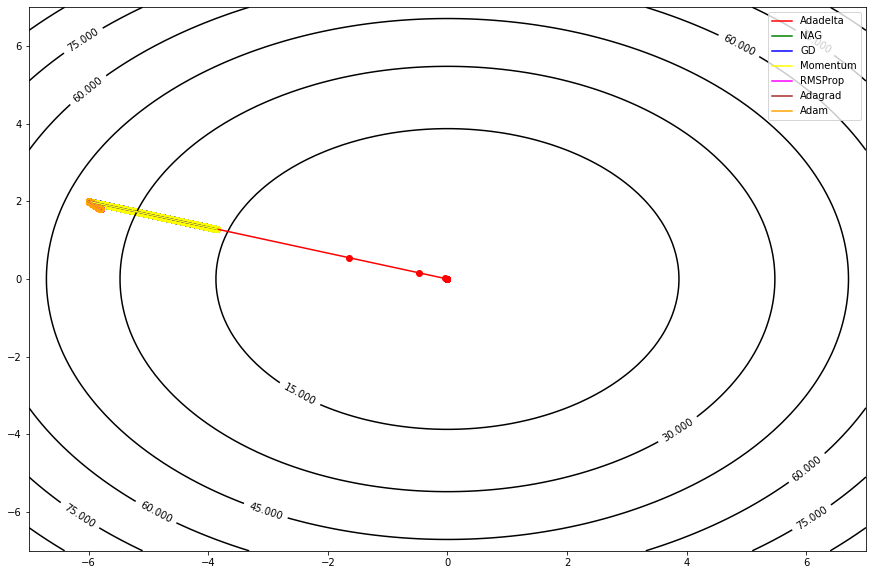

In [12]:
def J(x, y):
    return x**2 + y**2

x, y = make_var(1), make_var(2)

def err(J=J, x=x, y=y):
    return J(x, y)

size = 7

show_optim_res()

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

tensor([-7.0409], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-61.7714], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-61.5589], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-61.7709], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([5.9163], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([12.7864], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([6.0269], dtype=torch.float64, grad_fn=<AddBackward0>)


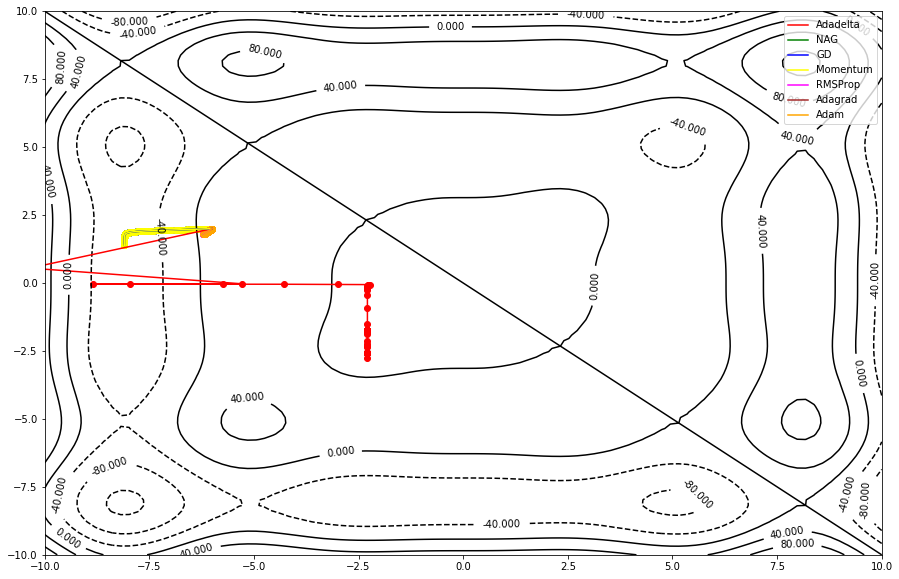

In [13]:
def J(x, y):
    if isinstance(x, np.ndarray):
        return x**2 * np.sin(x) + y**2 * np.sin(y)
    else:
        return x**2 * x.sin() + y**2 * y.sin()

x, y = make_var(1), make_var(2)

def err(J=J, x=x, y=y):
    return J(x, y)

size = 10

show_optim_res()

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

tensor([-11.0405], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([7.9654], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-34.2033], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.8018], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-40.9319], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-39.5197], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-40.8317], dtype=torch.float64, grad_fn=<AddBackward0>)


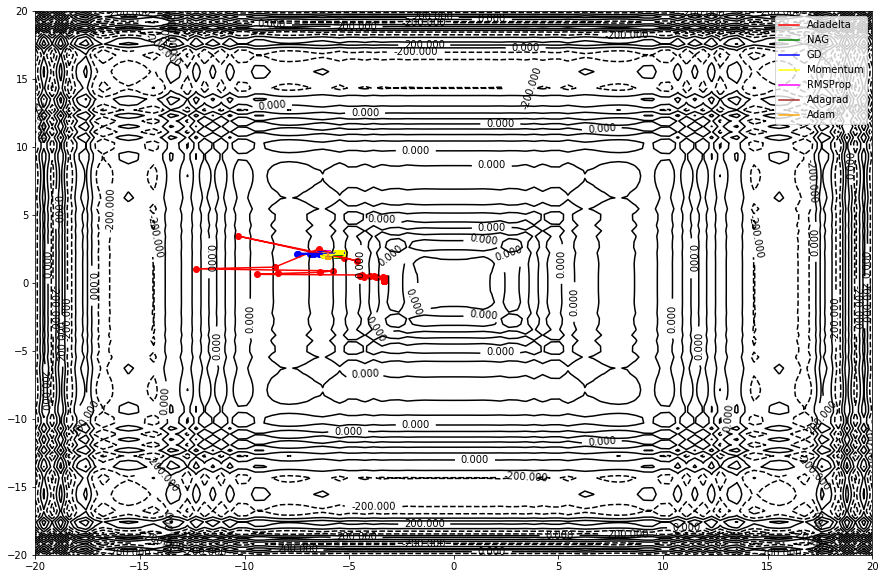

In [14]:
def J(x, y):
    if isinstance(x, np.ndarray):
        return x**2 * np.sin(x**2) + y**2 * np.sin(y**2)
    else:
        return x**2 * ((x**2).sin()) + y**2 * ((y**2).sin())

x, y = make_var(1), make_var(2)
    
def err(J=J, x=x, y=y):
    return J(x, y)

size = 20

show_optim_res()

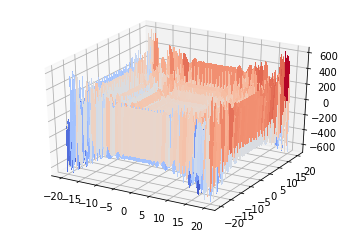

In [15]:
from mpl_toolkits.mplot3d import Axes3D

X = np.linspace(-size, size, 100)
Y = np.linspace(-size, size, 100)

X, Y = np.meshgrid(X, Y)
Z = J(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [16]:
transform = tsf.Compose([
                       tsf.ToTensor(),
                       tsf.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Epoch 4... (Train/Test) NLL: 0.198/0.222	Accuracy: 0.952/0.950


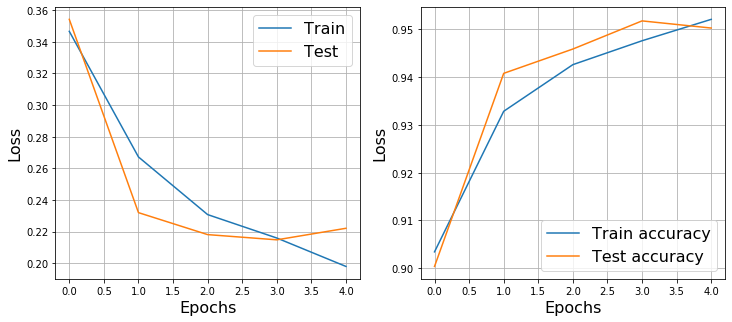

In [17]:
network = nn.Sequential(nn.Linear(784, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 10),
                       nn.LogSoftmax())
adam_tr_loss, adam_ts_loss,\
adam_tr_ac, adam_ts_ac = train(network, train_loader, test_loader,
                               5, 0.01, Adam)

Epoch 4... (Train/Test) NLL: 0.067/0.085	Accuracy: 0.981/0.971


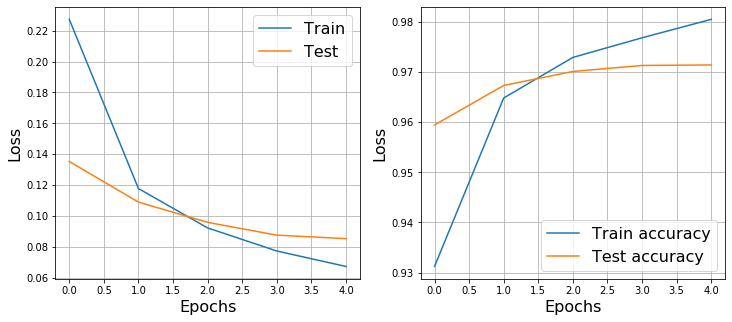

In [18]:
network = nn.Sequential(nn.Linear(784, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 10),
                       nn.LogSoftmax())
adagrad_tr_loss, adagrad_ts_loss,\
adagrad_tr_ac, adagrad_ts_ac = train(network, train_loader, test_loader,
                               5, 0.01, Adagrad)

Epoch 4... (Train/Test) NLL: 0.135/0.143	Accuracy: 0.960/0.958


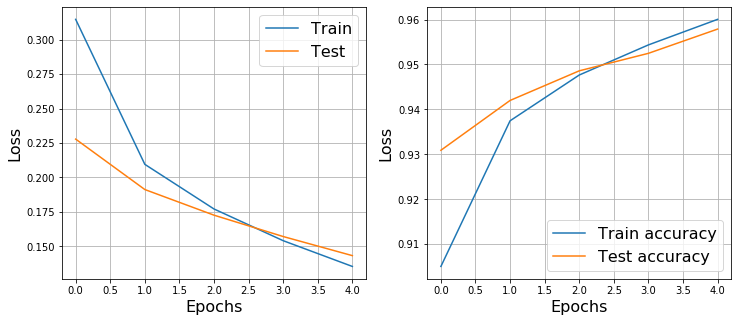

In [19]:
network = nn.Sequential(nn.Linear(784, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 100), 
                       nn.ReLU(),
                       nn.Linear(100, 10),
                       nn.LogSoftmax())
adadelta_tr_loss, adadelta_ts_loss,\
adadelta_tr_ac, adadelta_ts_ac = train(network, train_loader, test_loader,
                               5, 0.01, AdaDelta)

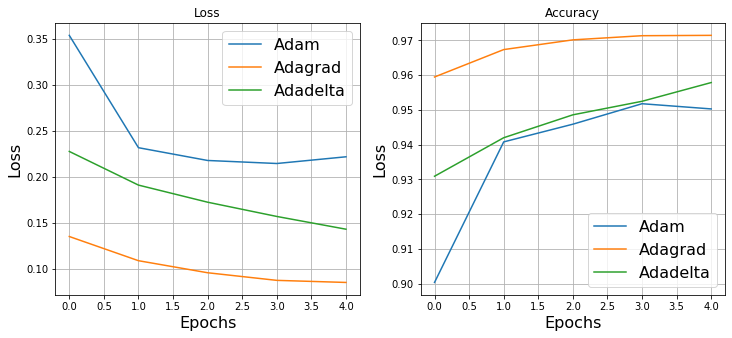

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(adam_ts_loss, label='Adam')
plt.plot(adagrad_ts_loss, label='Adagrad')
plt.plot(adadelta_ts_loss, label='Adadelta')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(adam_ts_ac, label='Adam')
plt.plot(adagrad_ts_ac, label='Adagrad')
plt.plot(adadelta_ts_ac, label='Adadelta')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [27]:
# input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 
# -> ReLU -> 32 Conv 3x3  -> ReLU -> maxpool -> 64 Conv 3x3 
# -> ReLU -> ravel -> Linear -> LogSoftmax

image_size = 28

class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), 
            nn.ReLU(), 
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU()
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(image_size // 2 * image_size // 2 * 64, 10), 
            nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.068/0.075	Accuracy: 0.979/0.976


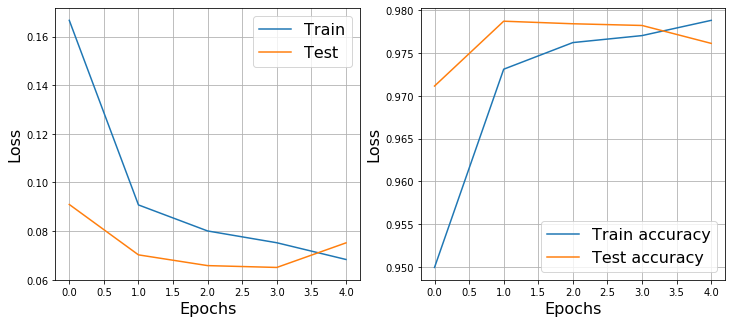

In [28]:
from train_utils import train

network = ConvClassifier(image_size=28)
adam_tr_loss, adam_ts_loss,\
adam_tr_ac, adam_ts_ac = train(network, train_loader, test_loader,
                               5, 0.01, optimizer=Adam, ravel_init=False)

Epoch 4... (Train/Test) NLL: 0.014/0.031	Accuracy: 0.996/0.991


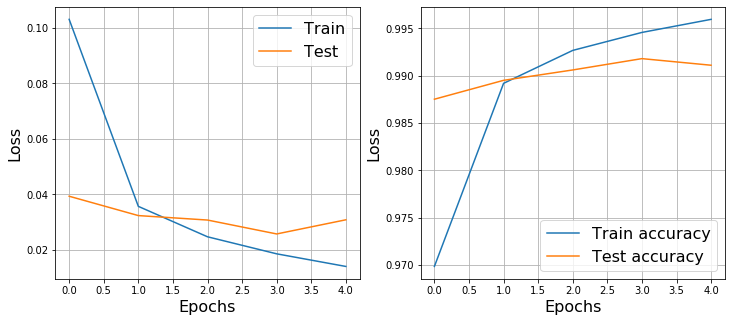

In [29]:
network = ConvClassifier(image_size=28)
adagrad_tr_loss, adagrad_ts_loss,\
adagrad_tr_ac, adagrad_ts_ac = train(network, train_loader, test_loader,
                               5, 0.01, optimizer=Adagrad, ravel_init=False)

Epoch 4... (Train/Test) NLL: 0.037/0.035	Accuracy: 0.989/0.989


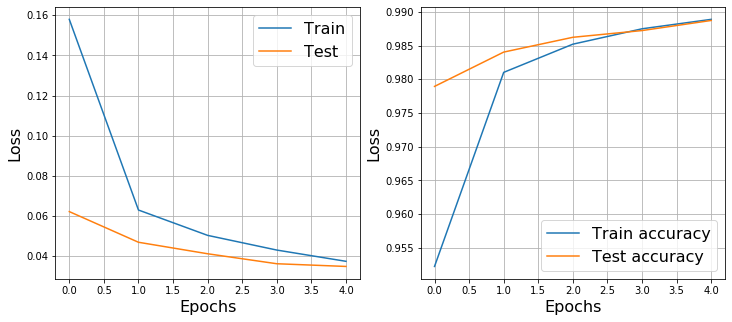

In [31]:
network = ConvClassifier(image_size=28)
adadelta_tr_loss, adadelta_ts_loss,\
adadelta_tr_ac, adadelta_ts_ac = train(network, train_loader, test_loader,
                               5, 0.01, optimizer=AdaDelta, ravel_init=False)

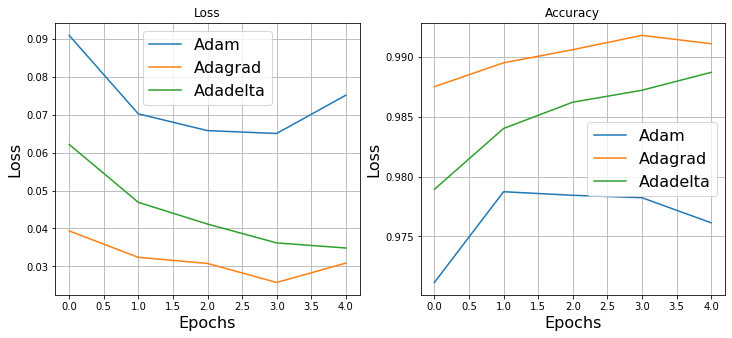

In [32]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(adam_ts_loss, label='Adam')
plt.plot(adagrad_ts_loss, label='Adagrad')
plt.plot(adadelta_ts_loss, label='Adadelta')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(adam_ts_ac, label='Adam')
plt.plot(adagrad_ts_ac, label='Adagrad')
plt.plot(adadelta_ts_ac, label='Adadelta')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

#### Вывод

Лучшие результаты показал Adagrad, на втором месте Adadelta, затем идет Adam. Однако у Adagrad и Adam не такая устойчивая зависимость между train и test результатами, как это наблюдается у Adadelta

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:

При использовании оптимизаторов во второй части домашнего задания у меня неправильно работала Adadelta с семинара